# How to computed the topological backbone of the cytoskeleton
In this notebook we illustrate how the algorithm presented in this work is able to extract the toplogy of actin filaments from electron tomography data. For the purose of visulization we created an artificial 2D test image. The extension to 3D is straight forward.

In [1]:
import numpy as np

import copy

import matplotlib.image as mpimg

from scipy import ndimage

from skimage.color import rgb2gray

#################################

import actin_geometry as ag

In [2]:
from importlib import reload#
reload(ag)

<module 'actin_geometry' from '/home/eberhardt/Spine/geometry_paper/submit/actin_geometry.py'>

## Connectivity mask

The mask sets the connectivity between individual pixels.
- 1 pixels are connected
- 0 pixels are not connected

Central pixel is conected to all pixels around it if mask is: <br />
[[1,1,1], <br />
[1,1,1], <br />
[1,1,1]] <br />


Central pixel connects to other pixels over its side but not over its edges if: <br />
[[0,1,0], <br />
[1,1,1], <br />
[0,1,0]] <br />

Remark: Here pixels are connected over sides and edges to get lines that
follow the filaments more accurately without sharp bends and edges

In [3]:
# connect pixels over sides and edges
mask_2d = [[1,1,1],[1,1,1],[1,1,1]]

## Load artificial data from images
- load ground truth (in gerneral there is no ground truth available, here it is only used for the visualization of the final results)
- load artifical test data image (this image is a noisy version of the ground_truth image)
- load mask (masks the extacellular space; 1 -> intracellular, 0-> extracellular)
- compute distance transfrom on intracellular space (provides a map for the distance to the closest  boundary at every point in the intracellular space)

In [4]:
# load ground truth
# in gerneral there is no ground truth available
# here it is only used for the visualization of the final result
ground_truth = mpimg.imread('./filaments_ground_truth.png')
ground_truth = rgb2gray(ground_truth)
ground_truth[np.where(ground_truth < 0.5)] = 0.
ground_truth[np.where(ground_truth >= 0.5)] = 1.
ground_truth= 1. - ground_truth




# image is a noisy version of the ground_truth image
img = mpimg.imread('./filaments_w_noise.png')
img = 1- (img / (np.max(img)- np.min(img))) # normalize values to range 0 to 1

# make a copy to have access to the original image later
ov_img = copy.copy(rgb2gray(img))

# load mask
# masks the extacellular space 
# 1: intracellular
# 0: extracellular
mask = mpimg.imread('./filaments_w_noise_mask.png')
mask = rgb2gray(mask)
mask[np.where(mask < 0.5)] = 0.
mask[np.where(mask >= 0.5)] = 1.
mask= 1. - mask

# distance to boundary
# compute distance transfrom on mask
mask_dst_trans = ndimage.distance_transform_edt(mask)

# remove extracellular space from data
mask_img = copy.copy(mask)
mask_img[np.where(mask_img==1.)] = np.nan

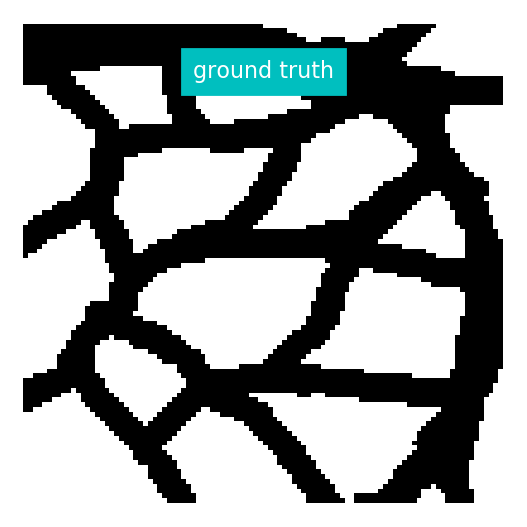

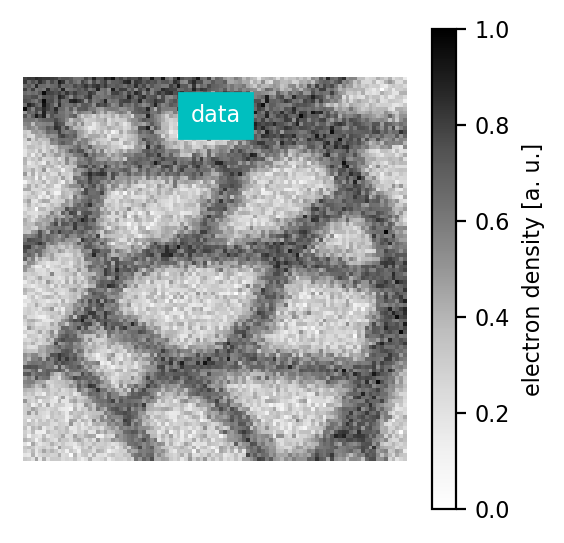

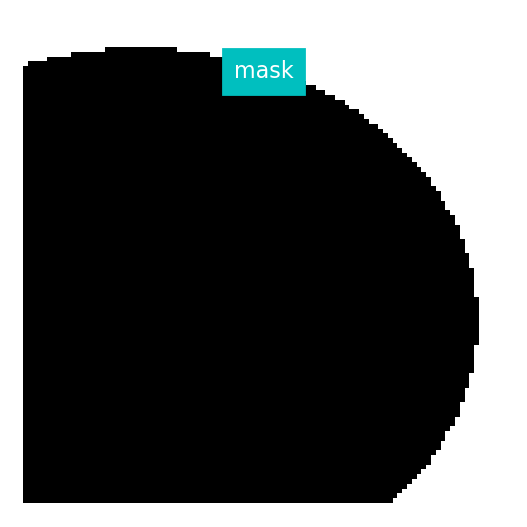

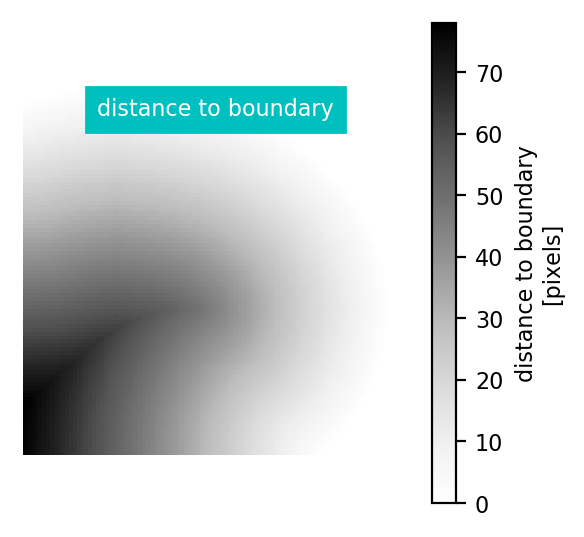

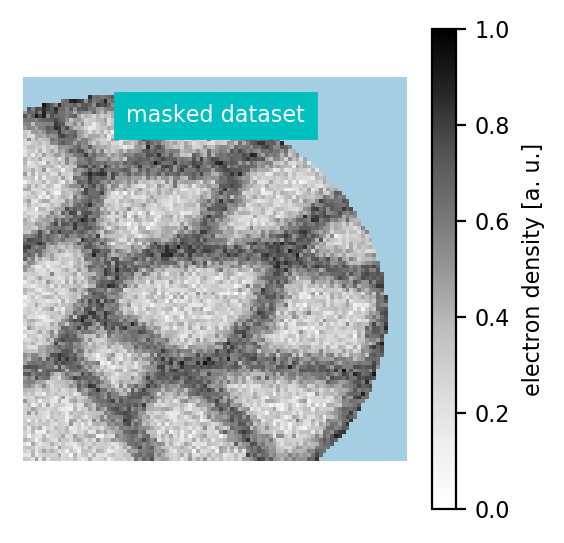

In [5]:
# show data, mask, and distance transform

ag.show_image([ground_truth],cmaps=['Greys'], title='ground truth')
ag.show_image([img],cmaps=['Greys'], title='data',cb_index=0, cb_label='electron density [a. u.]')
ag.show_image([mask],cmaps=['Greys'], title='mask')
ag.show_image([mask_dst_trans],cmaps=['Greys'], title='distance to boundary',cb_index=0, 
              cb_label='distance to boundary\n[pixels]')
ag.show_image([img,mask_img],cmaps=['Greys', 'Paired'], title='masked dataset',
              cb_index=0, cb_label='electron density [a. u.]')

## Filter image
Reduce the image noise in the masked data-set by smoothing the tomogram with a Gaussian kernel.

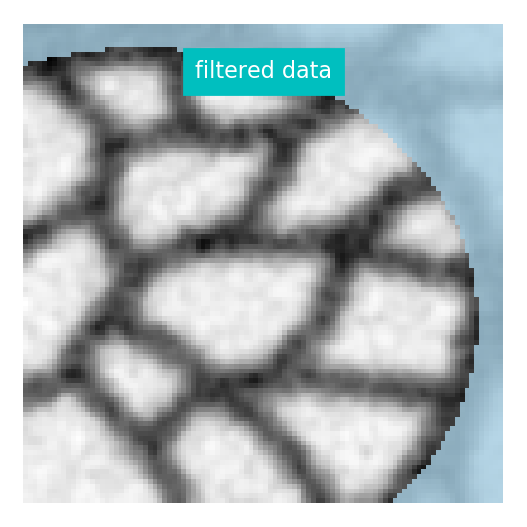

In [6]:
# filter image to reduce noise
# parameter sigma can be adjusted depending on the dataset
filtered_img=ndimage.gaussian_filter(img, sigma=1.0)


ag.show_image([filtered_img, mask_img], alphas=[1., .8], cmaps=['Greys', 'Paired'], title='filtered data')


## Binarization threshold

Binarize the image using a local threshold (Sauvola 2000), which divides the volumes into strongly stained regions (putative actin filaments) and weakly stained regions (fluid part of the cytosol consisting mainly of water).

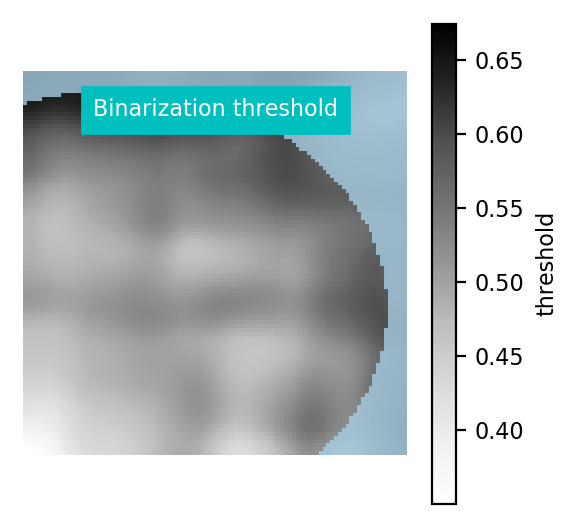

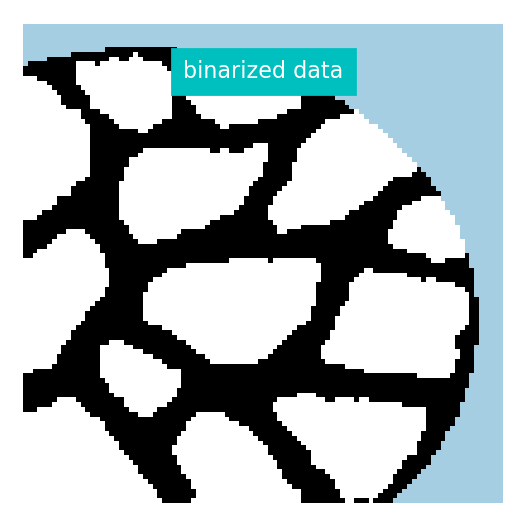

In [7]:
#compute threshold
#thresh = threshold_niblack(image=filtered_img,window_size=25,k=0.35, q=1.35) 
# the parameters window_size and k can be adjusted depending on the dataset
thresh = ag.threshold_sauvola(image=filtered_img,window_size=40,k=-0.1) 

ag.show_image([thresh, mask_img], alphas=[1., .8], cmaps=['Greys', 'Paired'], title='Binarization threshold',
             cb_index=0, cb_label='threshold')

# Segment Image
segmented_img = np.zeros(np.shape(img))
segmented_img[np.where(filtered_img >thresh)] = 1. # actin
segmented_img[np.where(filtered_img <=thresh)] = 0.  # water

ag.show_image([segmented_img, mask_img], alphas=[1., 1.], cmaps=['Greys', 'Paired'], title='binarized data')

## Detect unmasked mebrane
The manual segmentation of the dendritic spines in not entirely accurate and some regions of the membrane are not masked. These remaining parts of the membrane have to be removed before the filaments are traced.

/home/eberhardt/Spine/geometry_paper/submit/actin_geometry.py:180: RuntimeWarning: divide by zero encountered in true_divide
  window_size=window_size) / local_mean_filter(boundary_mask, window_size=window_size)
/home/eberhardt/Spine/geometry_paper/submit/actin_geometry.py:180: RuntimeWarning: invalid value encountered in true_divide
  window_size=window_size) / local_mean_filter(boundary_mask, window_size=window_size)


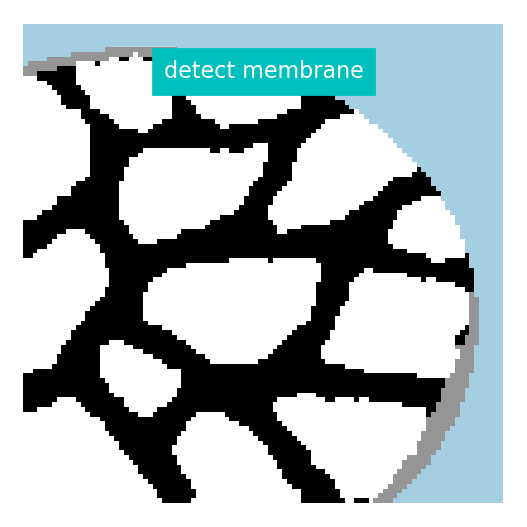

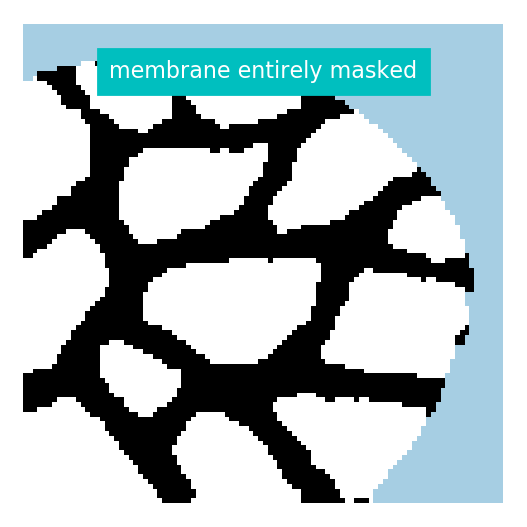

In [8]:
# dectec unmasked membrane
membrane_mask = ag.compute_membrane_mask(mask_dst_trans, segmented_img, smoothing=True, 
                                         max_boundary_distance=[2,4], membrane_cutoff=0.9
                                        )

tmp = copy.copy(segmented_img) # just for visulization
tmp[np.logical_and(membrane_mask==1., tmp==1.)] =.5
ag.show_image([tmp, mask_img], cmaps=['Greys', 'Paired'], 
              alphas=[1., 1.], title='detect membrane')

# correct mask
mask_corrected = copy.copy(mask)
mask_corrected[np.where(membrane_mask==1.)] = 0.

# correct binarized image
segmented_img_corrected = copy.copy(segmented_img)
segmented_img_corrected[np.logical_and(mask_corrected==0., segmented_img==1.)] = 0.

# visualize
tmp_mask_corrected = copy.copy(mask_corrected)
tmp_mask_corrected[np.where(tmp_mask_corrected==1.)] = np.nan
ag.show_image([segmented_img_corrected, tmp_mask_corrected], cmaps=['Greys', 'Paired'], alphas=[1., 1.], 
              title='membrane entirely masked')


## Detect branch end and cuts
Here points where the filaments connect to the boundary (intracellular/extracellular) are detected. Moreover some filaments continue behind the boundaries of the digital volume, these cuts are also detected. Later the thinning algorithm is not allowed to cut those connections between filaments and boundaries.

/home/eberhardt/anaconda2/envs/spineGeometryEnv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/eberhardt/anaconda2/envs/spineGeometryEnv/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


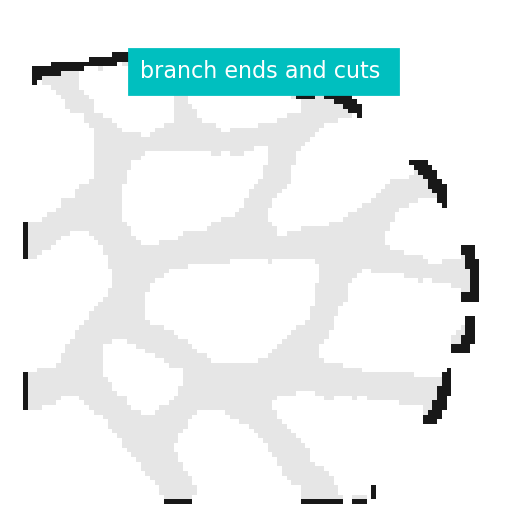

In [9]:
# surface
surface = copy.copy(segmented_img_corrected)

# detect branch ends (connections to membrane)
# dilate set of voxels containing the actin filaments in binary image
# set intracellular space pixels to zero again -> remaining pixels indicated connection to membrane
for i in range(2):
    surface = ag.binary_dilation(surface, structure=mask_2d).astype(segmented_img_corrected.dtype)
surface[np.where(mask_corrected==1.)]=0.

# add 1 pixel thin frame around image
nx, ny = np.shape(segmented_img_corrected)
tmp = np.zeros([nx+2, ny+2])
tmp[1:-1, 1:-1] = copy.copy(segmented_img_corrected)

# mark actin branches in frame at lower and left side of image 
# where filaments are cut 
tmp[-1,:]=  tmp[-2,:]/tmp[-2,:] *2.
tmp[:,0 ]=tmp[:,1]/tmp[:,1] *2.
tmp -= 1.
tmp[np.where(tmp != 1.)]=0.

# merge ends and cuts
tmp[1:-1, 1:-1] += surface
surface = copy.copy(tmp)

# show ends and cuts
tmp = np.zeros([nx+2, ny+2])
tmp[1:-1, 1:-1] = segmented_img_corrected
ag.show_image([surface,tmp], 
              cmaps=['Greys','Greys',], alphas=[1,0.1],
             title='branch ends and cuts ')


## Distance transform of filaments
Here the distance transform is applied to the set of voxels containing the filaments in the binarized image. This is different from the distance transform applied to the intracellulars space, computed above. Points in the centers of the filament volxels have the highes values.

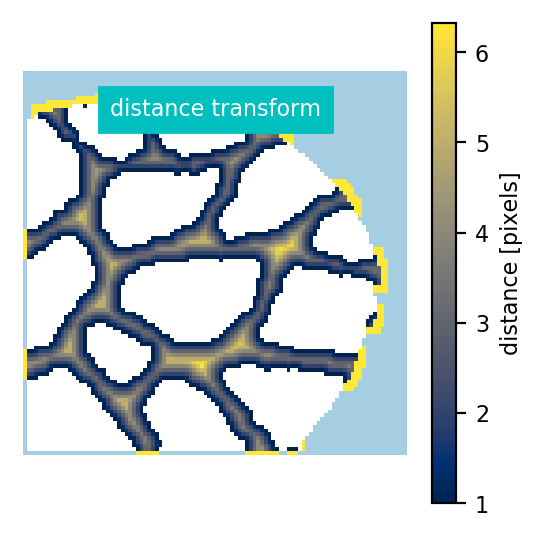

In [10]:
# Compute distance transform on binarized data
# centerlines of filaments get highest values
##dst_img = copy.copy(segmented_img_corrected)
dst_img = np.zeros([nx+2, ny+2])
dst_img[1:-1, 1:-1] = copy.copy(segmented_img_corrected)
dst_img[np.where(surface==1.)]=1.
dst_img=ndimage.distance_transform_edt(dst_img)
dst_img[np.where(surface==1.)] = 1000.


# remove everything except filaments and endpoints of filaments
# for visulization
tmp = copy.copy(dst_img)
tmp[np.where(tmp==1000.)] = 1.
#print(np.max(tmp))
tmp[np.where(surface==1.)] = np.max(tmp)
tmp[np.where(tmp==0)]= np.nan # extracellular space and background intracellular

# visulaize
tmp_mask = np.zeros([nx+2, ny+2])
tmp_mask[1:-1, 1:-1] = copy.copy(tmp_mask_corrected)
ag.show_image( [tmp_mask, tmp, ], cmaps=[ 'Paired', 'cividis',], 
              alphas=[1.,1.], title='distance transform', 
              cb_index=1, cb_label='distance [pixels]')



## Thinning
The voxels are sorted by their distance transform value. Voxels with lowes distancd transform are subsequently set to zero based on the following topology-preserving rules: voxels were kept if their removal would "break’’ a filament or dissociate a filament from the volume boundary, or if the voxel lay at the end of a filament branch. This procedure yielded lines of connected voxels representing the structure of the actin cytoskeleton

In [11]:
window_size = 11 # check topology within this window, can be adjusted depending on dataset

pixel_graph, N_removed = ag.find_pixel_graph_2d(dst_data_in=dst_img, structure=mask_2d, 
                                                   n_local=window_size, repeat=True, )

# Repeat thinning until no more pixels can be removed.
while N_removed > 0:
    pixel_graph, N_removed = ag.find_pixel_graph_2d(dst_data_in=pixel_graph, structure=mask_2d, 
                                                    n_local=window_size, 
                                                repeat=True)

global number of labels in distance transform of filaments before extracting pixel graph:  5
3178 voxels indexed in distance transform
0 of 3178 voxels checked...
1000 of 3178 voxels checked...
2000 of 3178 voxels checked...
3000 of 3178 voxels checked...
2448 voxels removed.
730 voxel remain in voxel graph
gloabal nuber of labels in pixel graph:  5
global number of labels in distance transform of filaments before extracting pixel graph:  5
730 voxels indexed in distance transform
0 of 730 voxels checked...
0 voxels removed.
730 voxel remain in voxel graph
gloabal nuber of labels in pixel graph:  5


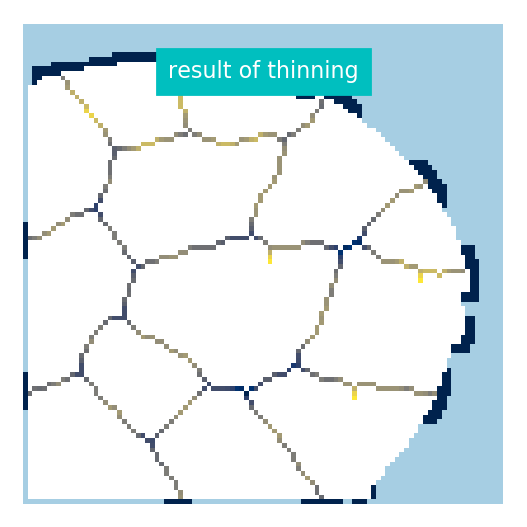

In [12]:
# show result of thinning
tmp = copy.copy(pixel_graph)
max_dst_val = np.max(tmp[np.where(tmp<1000)])
tmp[np.where(tmp==1000)]=max_dst_val
tmp[np.where(tmp==0)]=np.nan
#show_image([tmp], )
ag.show_image( [tmp_mask, tmp, ], cmaps=[ 'Paired', 'cividis_r',], 
              alphas=[1.,1.], title='result of thinning' )

## Remove small end tips
Structures that are smaller than the smallest expected structures (4 nm in the case of actin) are removed, which almost exclusively removes small branch ends. Such putative “actin-stubs” are quite possibly the result of imaging noise.

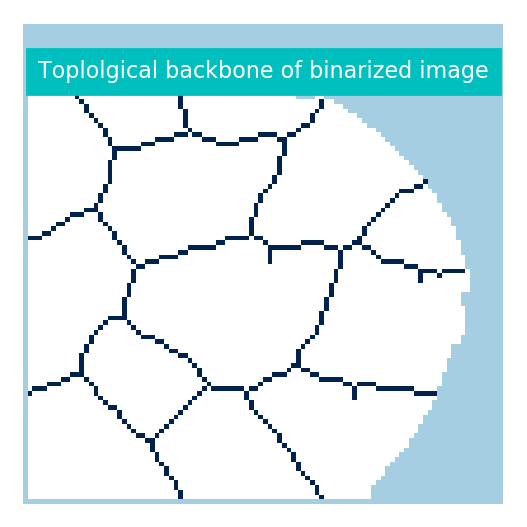

[ 1. nan nan ... nan nan nan]
small end branches removed:  3
global number of labels in distance transform of filaments before extracting pixel graph:  1
409 voxels indexed in distance transform
0 of 409 voxels checked...
2 voxels removed.
407 voxel remain in voxel graph
gloabal nuber of labels in pixel graph:  1
small end branches removed:  0
global number of labels in distance transform of filaments before extracting pixel graph:  1
407 voxels indexed in distance transform
0 of 407 voxels checked...
0 voxels removed.
407 voxel remain in voxel graph
gloabal nuber of labels in pixel graph:  1


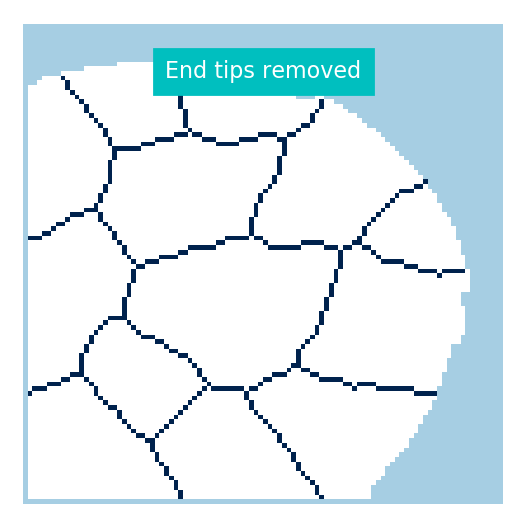

In [13]:
# make graph binary
pixel_graph[np.where(pixel_graph==1000)]=0.
pixel_graph[np.where(pixel_graph>0)]=1.
pixel_graph[np.where(pixel_graph==0.)]=0.

# visulize
tmp = copy.copy(pixel_graph)
tmp[np.where(tmp==0.)]=np.nan
ag.show_image([tmp_mask, tmp, ], 
              cmaps=[ 'Paired', 'cividis',], alphas=[1.,1.],
             title='Toplolgical backbone of binarized image')
print(np.unique(tmp))

# remove small end tips
# 1. remove small end branches and small fragments that are shorter than the smalles elements of the expected structure
# 2. test if voxels can be removed from pixel graph
# 3. repeat 1 & 2 until no branches and pixels can be removed any more
# min length of end tips can be adjusted depending on dataset
b_removed = 1
N_removed = 1
while N_removed >0 or b_removed > 0:
    pixel_graph, b_removed = ag.remove_small_end_tips(pixel_graph, mask_2d, min_end_length=6)
    pixel_graph, N_removed = ag.find_pixel_graph_2d(pixel_graph, n_local=window_size, structure=mask_2d)
    pixel_graph = ag.remove_small_fragments(pixel_graph, structure=mask_2d, min_fragment_size=6)

# show result
tmp = copy.copy(pixel_graph)
tmp[np.where(tmp==0.)]=np.nan
ag.show_image([tmp_mask, tmp, ], 
              cmaps=[ 'Paired', 'cividis',], alphas=[1.,1.],
             title='End tips removed')




## Graph topology
A voxel connected to exactly two other voxels was considered to be part of a branch. A voxel connected to more than two other voxels was classified as a node (branching point). Voxels connected to only one other voxel were classified as branch ends.

number of nodes: 14
number of ends:  6
number of cuts:  4


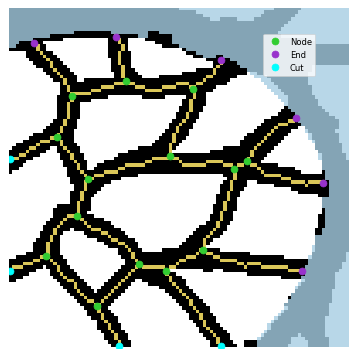

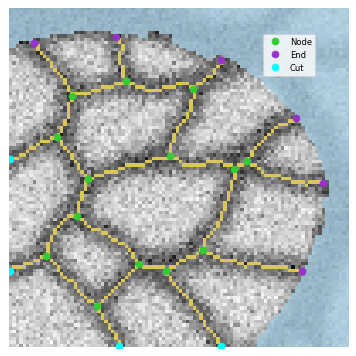

In [14]:
# remove frame again
pixel_graph = pixel_graph[1:-1,1:-1]
segmented_pixel_graph = ag.segment_pixel_graph(pixel_graph, 
                                               structure=mask_2d)

nodes_dict = ag.identify_nodes(segmented_pixel_graph, 
                               structure=mask_2d)

ag.show_geometry(ov_img=ground_truth, pixel_graph=pixel_graph, 
           mask=mask_corrected, nodes=nodes_dict,
           title='', ms=10)

ag.show_geometry(ov_img=ov_img, pixel_graph=pixel_graph,
           mask=mask_corrected, nodes=nodes_dict,
           title='', ms=10)